## Introduction ##

This notebook is designed to simulate the 3d comb percolation process. The function of the code is similar to the code presented in 'General_Layer_Percolation_Visualization.ipynb', however in a less general format which only work with the 3d comb percolation law.  

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Simulation ##

In [2]:
#Function for offsetting shape associated to each cell
def get_offsets(cell, shape):
    offset_cells = []
    for shape_cell in shape:
        #For each cell in the shape, take the right coordinate from the shape, take the sleep coordinate from both the shape and the cell
        offset_cells.append(tuple(np.array([shape_cell[0], shape_cell[1], shape_cell[2]])+np.array([0, cell[1], cell[2]])))
    return offset_cells

In [3]:
#This function takes in an unordered array of cells and partitions it into an array of diagonals. 
def partition_into_layers(newly_invaded_cells):
    flat_list = []
    num_layers = 0
    for list in newly_invaded_cells:
        for element in list:
            #Find the largest layer in the set of newly invaded cells
            if element[0]+element[1]+element[2] > num_layers:
                num_layers = element[0]+element[1]+element[2]
            flat_list.append(element)

    invaded_layers = []
    
    for layer in range(num_layers+1):
        layer_i = []
        for cell in flat_list:
            #Only add a cell if it's not already in the layer, so we are not keeping repeat cells
            if cell[0]+cell[1]+cell[2] == layer and (cell[0], cell[1], cell[2]) not in layer_i:
                layer_i.append((cell[0], cell[1], cell[2]))
        invaded_layers.append(layer_i)   
    return invaded_layers

In [4]:
#This function takes in a set of invaded cells separated into diagonals and a sleep rate, 
#and returns the instruction stacks at the spine and tooth as well as an array of newly invaded cells 
#after one step of the comb percolation process. The returned array has 3 components, the first two are the instruction stack strings
#and the third is an array of newly invaded cells, separated into diagonals already
def run_comb_percolation_step(invaded_cells, sleep_rate):
    tooth_instruction_stack = ''
    spine_instruction_stack = ''
    newly_invaded_cells = []
    #Assumes invaded_cells is an array of diagonals containing cells
    num_layers = len(invaded_cells)
    shape_array = []
    r_counter = 0
    for i in range(num_layers):
        #Each shape starts with the 0th cell. This is if 
        shape_i = []
        #Number of U's between successive L's 
        u_i = np.random.geometric(1/2) - 1
        #Counting the spaces to need one more than the number of U's
        for j in range(u_i+1):
            #Inheritance
            if i == 0 or j != 0:
                tooth_sleep_indicator = 0
                l = random.random()
                #Check if there is a sleep before the next down instruction in the tooth stack
                if l < sleep_rate/(1+sleep_rate):
                    tooth_instruction_stack += 'S'
                    tooth_sleep_indicator = 1
                tooth_instruction_stack += 'D'
            #Number of R's between sucessive U's
            r_j = np.random.geometric(2/3)-1
            #Counting the spaces so need one more than the number of R's
            for k in range(r_j+1):
                #Dont want duplicate cells for clarity
                if (r_counter, 0) not in shape_i:
                    shape_i.append((r_counter, 0, 0))
                if (r_counter, tooth_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, 0, tooth_sleep_indicator))
            
                spine_sleep_indicator = 0
                #Check if there is a sleep instruction in the spine stack before the next move instruction
                l = random.random()
                if l < sleep_rate/(1+sleep_rate):
                    spine_sleep_indicator = 1
                    spine_instruction_stack += 'S'
                    
                if (r_counter, spine_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, spine_sleep_indicator, 0))
                if (r_counter, spine_sleep_indicator+tooth_sleep_indicator) not in shape_i:
                    shape_i.append((r_counter, spine_sleep_indicator, tooth_sleep_indicator))
                
                if k != 0:
                    spine_instruction_stack += 'R'
                #Increment the number of R's which have been used so far
                r_counter += 1
            if j != 0:
                spine_instruction_stack += 'U'
            #Overcounted the number of R's, so subtract one
            r_counter -= 1
        shape_array.append(shape_i)
        spine_instruction_stack += 'L'
    
    for i, diagonal in enumerate(invaded_cells):
        shape_i = shape_array[i]
        for cell in diagonal:
            offset_cells = get_offsets(cell, shape_i)
            newly_invaded_cells.append(offset_cells)
    
    newly_invaded_cells = partition_into_layers(newly_invaded_cells)
    return [tooth_instruction_stack, spine_instruction_stack, newly_invaded_cells]

In [5]:
def find_largest_sleep_coords(invaded_cells):
    s_max = 0
    s_prime_max = 0
    for layer in invaded_cells:
        for cell in layer:
            if cell[1] > s_max:
                s_max = cell[1]
            if cell[2] > s_prime_max:
                s_prime_max = cell[2]
    return [s_max, s_prime_max]

## Running Simulations ## 

In [29]:
#Change if you want different parameters
num_steps = 10
sleep_rate = 0.5
num_trials = 1


total_s_density = 0
total_s_prime_density = 0
for trial in range(num_trials):
    #Begin with the origin invaded, double [[]] as this is an array of diagonals (which are arrays of cells in the diagonal)
    invaded_cells = [[(0,0,0)]]
    for step in range(num_steps):
        print("Trial: "+str(trial)+" Iteration: "+str(step), end="\r")
        #The output of run_comb_percolation_step also includes the instruction stacks at the spine and tooth, we just throw them away for now
        [tooth_instruction_stack, spine_instruction_stack, invaded_cells] = run_comb_percolation_step(invaded_cells, sleep_rate)
    
    [s_max, s_prime_max] = find_largest_sleep_coords(invaded_cells)
    total_s_density += s_max/num_steps
    total_s_prime_density += s_prime_max/num_steps

## Plotting ##

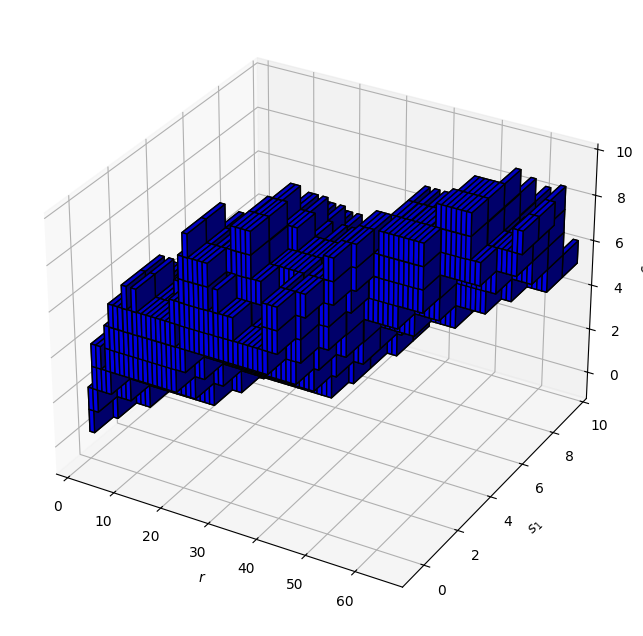

In [35]:
# Formatting: the invaded_cells array is a list of diagonals, so unwrap into coordinates
points = [pt for diag in invaded_cells for pt in diag]
points_array = np.array(points)

# Create figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Only plot if there are points
if len(points_array) > 0:
    # Get min/max coordinates for axis limits
    x_min, y_min, z_min = np.min(points_array, axis=0)
    x_max, y_max, z_max = np.max(points_array, axis=0)
    
    # Create voxel grid
    voxel_grid = np.zeros((x_max + 2, y_max + 2, z_max + 2), dtype=bool)
    
    # Mark occupied voxels
    for (x, y, z) in points_array:
        voxel_grid[x, y, z] = True
    
    # Plot voxels
    ax.voxels(voxel_grid, facecolors='blue', edgecolor='k', alpha=1)
    
    # Set axis limits
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_zlim(z_min - 1, z_max + 1)

# Set axis labels (must be called on ax for 3D plots)
ax.set_xlabel("$r$")
ax.set_ylabel("$s_1$")
ax.set_zlabel("$s_2$")

# Save figure
plt.savefig('3d_comb_percolation_plot.png', dpi=300)
